In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

# 1D Beam Solution

In [2]:
bc = 1  # constrain (or Boundary condition) at node 1
E = 70000   # Youngs Modulus
I = 300*40**3/12  # Area Moment of Inertia 
L = 1500  # Length of Bar
F = 4000   # Force at the tip of Bar
numElem = 2  # Number of Elements

In [3]:
le = L/numElem

elem = []
for i in range(numElem):
    elem.append([i+1,i+2])
elem

[[1, 2], [2, 3]]

In [4]:
x = Symbol('x')
Le = Symbol('Le')

# Shape Function Matrix
shape = np.matrix([
    (2*(x/le)**3 - 3*(x/le)**2 + 1),
    ((x/le)**3 - 2*(x/le)**2 + (x/le))*le,
    (-2*(x/le)**3 + 3*(x/le)**2),
    ((x/le)**3 - (x/le)**2)*le
])

# Differentiated Shape Function Matrix
shape_d = []
for i in range(shape.shape[1]):
    shape_d.append(diff(diff(np.array(shape[0, i]).flatten()[0], x), x))

shape = np.matrix(shape)
shape_d = np.matrix(shape_d)

shape, shape_d

(matrix([[4.71245672629921e-9*x**3 - 5.31209917300806e-6*x**2 + 1,
          1.77069972433602e-6*x**3 - 0.00266135283217842*x**2 + 1.0*x,
          -4.71245672629921e-9*x**3 + 5.31209917300806e-6*x**2,
          1.77069972433602e-6*x**3 - 0.00133067641608921*x**2]],
        dtype=object),
 matrix([[2.82747403577953e-8*x - 1.06241983460161e-5,
          1.06241983460161e-5*x - 0.00532270566435683,
          1.06241983460161e-5 - 2.82747403577953e-8*x,
          1.06241983460161e-5*x - 0.00266135283217842]], dtype=object))

In [5]:
# Creating The Local Stiffness Matrix

k = np.matmul(shape_d.T, shape_d)
for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        k[i,j] = simplify(integrate(k[i,j], x).subs(x, Le))
k

matrix([[Le*(2.66486980766912e-16*Le**2 - 3.00396449743324e-13*Le + 1.12873590495492e-10),
         Le*(1.00132149914441e-13*Le**2 - 1.31685855578074e-10*Le + 5.65494807155905e-8),
         Le*(-2.66486980766912e-16*Le**2 + 3.00396449743324e-13*Le - 1.12873590495492e-10),
         Le*(1.00132149914441e-13*Le**2 - 9.40613254129098e-11*Le + 2.82747403577953e-8)],
        [Le*(1.00132149914441e-13*Le**2 - 1.31685855578074e-10*Le + 5.65494807155905e-8),
         Le*(3.76245301651639e-11*Le**2 - 5.65494807155905e-8*Le + 2.83311955893763e-5),
         Le*(-1.00132149914441e-13*Le**2 + 1.31685855578074e-10*Le - 5.65494807155905e-8),
         Le*(3.76245301651639e-11*Le**2 - 4.24121105366929e-8*Le + 1.41655977946882e-5)],
        [Le*(-2.66486980766912e-16*Le**2 + 3.00396449743324e-13*Le - 1.12873590495492e-10),
         Le*(-1.00132149914441e-13*Le**2 + 1.31685855578074e-10*Le - 5.65494807155905e-8),
         Le*(2.66486980766912e-16*Le**2 - 3.00396449743324e-13*Le + 1.12873590495492e-10),
  

In [6]:
K = np.zeros([2*len(elem)+2, 2*len(elem)+2])  # Creating initially zero matrix for global stiffness matrix

for i in elem:
    temp = k.copy()
    for a in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            temp[a,j] = temp[a,j].subs(Le, le)
    K[2*i[0]-2:2*i[1], 2*i[0]-2:2*i[1]] = K[2*i[0]-2:2*i[1], 2*i[0]-2:2*i[1]] +  (E*I) * temp

In [7]:
def BC(K, bc):
    newK = []
    for i in range(len(K)):
        temp = []
        for j in range(len(K[0])):
            if not(i==bc or j==bc or i==bc+1 or j==bc+1):
                temp.append(K[i][j])
        if temp != []:
            newK.append(temp)
    if newK != []:
        return np.matrix(newK)
    else:
        return np.matrix(K)

In [8]:
# Global Stiffness Matrix After Applying Boundary Conditions
Kc = BC(K, bc-1)

In [9]:
# Creating Force Vector
f = np.zeros([len(Kc), 1])
f[-4] = F
f

array([[3955.],
       [   0.],
       [   0.],
       [   0.]])

In [10]:
# Obtaining the Nodal Displacement Vector
u = np.linalg.solve(Kc, f)
u = list(u)
u.insert(0, [0])
u.insert(0, [0])
u = np.matrix(u)
u

matrix([[0.00000000e+00],
        [0.00000000e+00],
        [3.30224773e+00],
        [6.59133477e-03],
        [8.25561934e+00],
        [6.59133477e-03]])

In [11]:
# Obtaining the Full force Vector including the Reaction Force
Force = np.matmul(K, u)
Force

matrix([[   -3955.        ],
        [-2972172.61250012],
        [    3955.        ],
        [       0.        ],
        [       0.        ],
        [       0.        ]])

In [12]:
# Calculation the Strains using the nodal displacement vector
strain = []
for i in elem:
    temp = []
    for a in range(shape_d.size):
        temp.append(shape_d[0,a].subs(x, Le).subs(Le, le))
    temp = np.matrix(temp)   
    strain.append(np.matmul(temp, u[2*i[0]-2:2*i[1], 0]))
strain

[matrix([[2.64274279543342e-19]], dtype=object), matrix([[0]], dtype=object)]

In [13]:
# Calculation Stress
y = 45.37/2
stress = E * np.array(strain) * y
stress

array([[[4.25745325224793e-13]],

       [[0]]], dtype=object)

In [14]:
a = le
# u_act = (F*L**3/(3*E*I))
u_act = (F/(6*E*I))*a**2*(3*L-a)

print('Hand Caluclation for Tip Deflection:', u_act)
print('FEM Tip Deflection:', u[-2,0])
print('% Error:', (u_act-u[-2,0])*100/u_act)

Hand Caluclation for Tip Deflection: 8.25561933635633
FEM Tip Deflection: 8.255619336356796
% Error: -5.637438851780626e-12


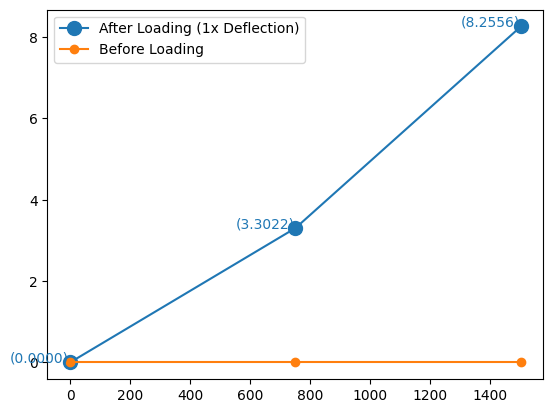

In [15]:
Multiplier = 1

uu = []
for i in range(1, len(u)+1):
    if i%2!=0:
        uu.append([u[i-1, 0]])
uu = np.matrix(uu)
        
x1 = [[0]]
te = 0
for i in range(len(uu)-1):
    te = te + le
    x1.append([te])
x1 = np.matrix(x1)

x = [[0]]
te = 0
for i in range(len(uu)-1):
    te = te + ((le)**2 - (uu[i+1,0]*Multiplier)**2)**0.5
    x.append([te])
x = np.matrix(x)

y = [[0]]
te = 0
for i in range(len(uu)-1):
    te = uu[i+1,0]*Multiplier
    y.append([te])
y = np.matrix(y)


plt.plot(x, y, marker='o', color='tab:blue', markersize=10, label=f'After Loading ({Multiplier}x Deflection)')
ind = 0
for i in zip(x,y):
    plt.annotate('(%.4f)'% (uu[ind,0]), xy=i, xytext=(x[ind]-200,y[ind]+0.0005), color='tab:blue')
    ind = ind+1

plt.plot(x1, np.zeros([x1.size,1]), marker='o', color='tab:orange', label='Before Loading')
plt.legend()